<a href="https://colab.research.google.com/github/Visa110804/Time-series-forecasting/blob/main/Time_series_forrecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Step 1: Upload CSV file to Colab
from google.colab import files
uploaded = files.upload()


Saving Weather_Data.csv to Weather_Data.csv


/tmp/ipython-input-1670843114.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


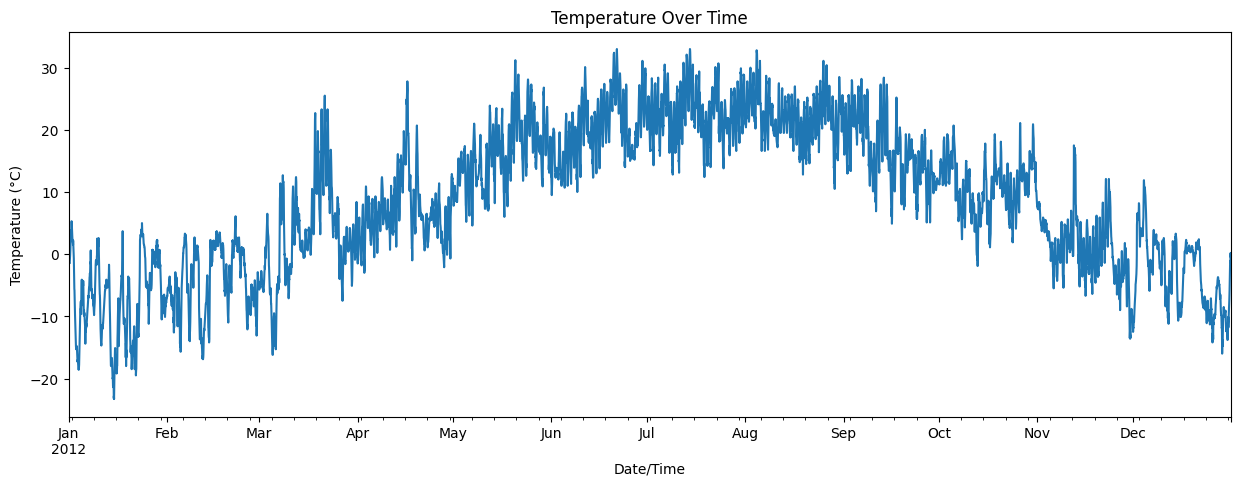

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/tmp/ipython-input-1670843114.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(predictions.index[-1], predictions[-1], 'ro', label='Next Hour Forecast')


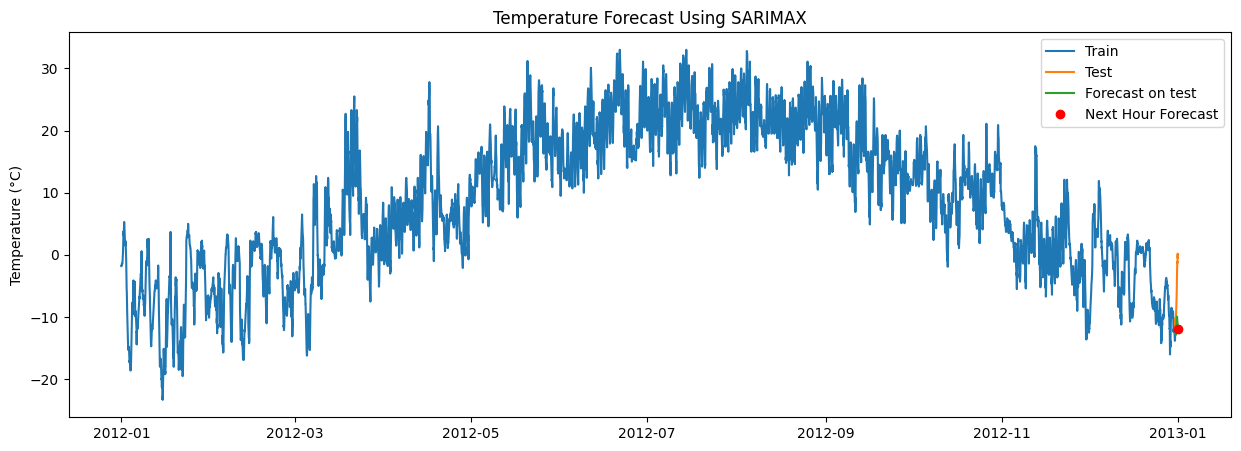

Test RMSE: 6.96
Predicted temperature for the next hour (2013-01-01 00:00:00): -11.98 °C


/tmp/ipython-input-1670843114.py:63: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Predicted temperature for the next hour ({predictions.index[-1]}): {predictions[-1]:.2f} °C")


In [5]:
# Step 2: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import rmse

# Step 3: Load the uploaded CSV file
df = pd.read_csv('Weather_Data.csv')

# Step 4: Convert datetime column and set as index
# Assuming there's a datetime column – if not, you’ll need to add/parse it
# If it's missing, let me know!
if 'Date/Time' in df.columns:
    df['Date/Time'] = pd.to_datetime(df['Date/Time'])
    df.set_index('Date/Time', inplace=True)
else:
    print("❌ The dataset doesn't include a 'Date/Time' column.")
    # Optional: create a fake datetime index for testing
    df.index = pd.date_range(start='2023-01-01', periods=len(df), freq='H')
    print("✅ A synthetic hourly datetime index was created.")

# Step 5: Handle missing values
df = df.fillna(method='ffill')

# Step 6: Use the correct temperature column
temperature = df['Temp_C']

# Step 7: Visualize the temperature data
temperature.plot(figsize=(15,5), title='Temperature Over Time')
plt.ylabel('Temperature (°C)')
plt.show()

# Step 8: Split into train and test sets (last 24 hours for testing)
train = temperature[:-24]
test = temperature[-24:]

# Step 9: Fit SARIMAX model
model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,24))
model_fit = model.fit(disp=False)

# Step 10: Predict for test set + 1 hour ahead
start = len(train)
end = start + len(test)  # up to last test hour
predictions = model_fit.predict(start=start, end=end)

# Step 11: Plot actual vs predicted
plt.figure(figsize=(15,5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(predictions.index[:-1], predictions[:-1], label='Forecast on test')
plt.plot(predictions.index[-1], predictions[-1], 'ro', label='Next Hour Forecast')
plt.legend()
plt.title('Temperature Forecast Using SARIMAX')
plt.ylabel('Temperature (°C)')
plt.show()

# Step 12: Evaluate model
test_rmse = rmse(test, predictions[:-1])
print(f'Test RMSE: {test_rmse:.2f}')

# Step 13: Show next hour forecast
print(f"Predicted temperature for the next hour ({predictions.index[-1]}): {predictions[-1]:.2f} °C")


In [4]:
print(df.columns.tolist())



['Temp_C', 'Dew Point Temp_C', 'Rel Hum_%', 'Wind Speed_km/h', 'Visibility_km', 'Press_kPa', 'Weather']


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load your dataset (already uploaded as Weather_Data.csv)
df = pd.read_csv('Weather_Data.csv')

# Parse datetime and set index
df['Date/Time'] = pd.to_datetime(df['Date/Time'])
df.set_index('Date/Time', inplace=True)

# Forward-fill missing values
df = df.fillna(method='ffill')

# Extract temperature series
temperature = df['Temp_C']

# Check if target prediction time exists
target_time = pd.Timestamp('2013-01-01 01:00:00')
if target_time not in temperature.index:
    print(f"Target time {target_time} not in dataset.")
else:
    print(f"Target time {target_time} exists in dataset.")

# Use data up to just before target time for training
train = temperature.loc[:target_time - pd.Timedelta(hours=1)]

# Fit SARIMAX model (basic seasonal config, can be tuned)
model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,24))
model_fit = model.fit(disp=False)

# Forecast up to the target time
pred = model_fit.predict(start=target_time, end=target_time)

# Display the predicted temperature
print(f"🌡️ Predicted temperature at {target_time}: {pred.iloc[0]:.2f} °C")


/tmp/ipython-input-3872750961.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Target time 2013-01-01 01:00:00 not in dataset.
🌡️ Predicted temperature at 2013-01-01 01:00:00: -0.29 °C


/tmp/ipython-input-1666609901.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/tmp/ipython-input-1666609901.py:32: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_index = pd.date_range(start=last_datetime + pd.Timedelta(hours=1), periods=n_steps, freq='H')


📈 Forecast for the next 10 hours:
2013-01-01 00:00:00   -0.039249
2013-01-01 01:00:00   -0.292094
2013-01-01 02:00:00   -0.419239
2013-01-01 03:00:00   -0.749389
2013-01-01 04:00:00   -0.937018
2013-01-01 05:00:00   -1.005018
2013-01-01 06:00:00   -0.928498
2013-01-01 07:00:00   -0.909474
2013-01-01 08:00:00   -0.566085
2013-01-01 09:00:00    0.035153
Freq: h, dtype: float64


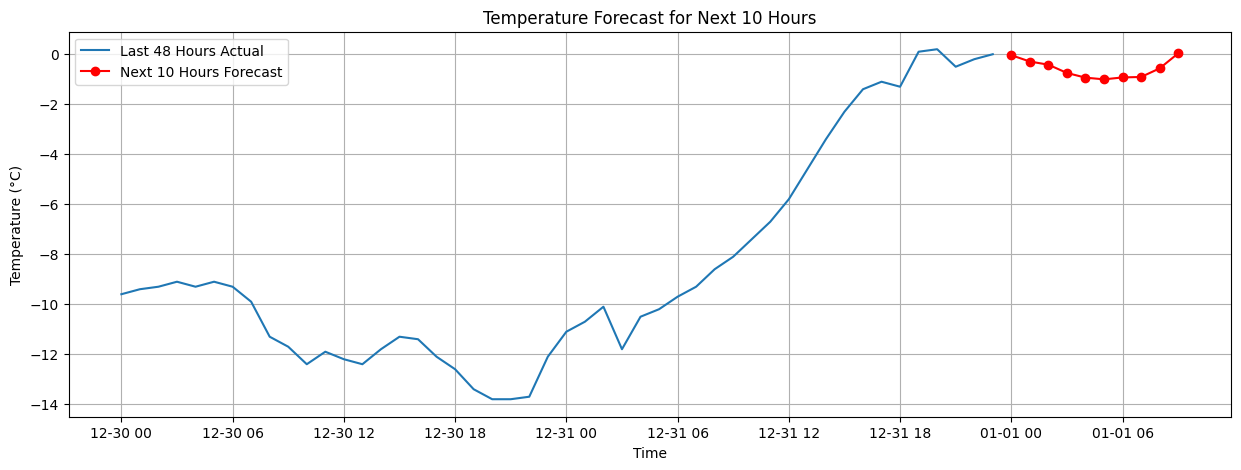

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Step 1: Load data
df = pd.read_csv('Weather_Data.csv')

# Step 2: Parse datetime and set index
df['Date/Time'] = pd.to_datetime(df['Date/Time'])
df.set_index('Date/Time', inplace=True)

# Step 3: Handle missing values
df = df.fillna(method='ffill')

# Step 4: Use temperature column
temperature = df['Temp_C']

# Step 5: Fit SARIMAX model on the full dataset
model = SARIMAX(temperature, order=(1,1,1), seasonal_order=(1,1,1,24))
model_fit = model.fit(disp=False)

# Step 6: Forecast next 10 hours
n_steps = 10
start = len(temperature)
end = start + n_steps - 1

forecast = model_fit.predict(start=start, end=end)

# Step 7: Create datetime index for forecast
last_datetime = temperature.index[-1]
forecast_index = pd.date_range(start=last_datetime + pd.Timedelta(hours=1), periods=n_steps, freq='H')
forecast_series = pd.Series(forecast.values, index=forecast_index)

# Step 8: Print the forecast
print("📈 Forecast for the next 10 hours:")
print(forecast_series)

# Step 9: Plot the forecast
plt.figure(figsize=(15, 5))
plt.plot(temperature[-48:], label='Last 48 Hours Actual')  # show last 2 days
plt.plot(forecast_series, label='Next 10 Hours Forecast', color='red', marker='o')
plt.title("Temperature Forecast for Next 10 Hours")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.show()
